### Tasks
* Implement Faiss - (create a util file using code given by gaurav and import here) 
* Implement Near Neighbor Sampling 
* plot the gradients for each batch (==1, should be high) and for the entire dataset(should be low) at different interesting epochs 
* Figure out how to calculate efficient per sample gradient 


In [177]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import time

#replace with pytorch lightning
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

from indx import *
from query import *

In [2]:
print(torch.__version__)

1.12.1+cu116


In [3]:
device = torch.device("cpu")
device = torch.device(device)
print(device)

cpu


In [4]:
df=pd.read_csv("HIGGS.csv",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [5]:
#subsample
df = df[:600000]

In [6]:
print(df.size)

17400000


<AxesSubplot:xlabel='0', ylabel='count'>

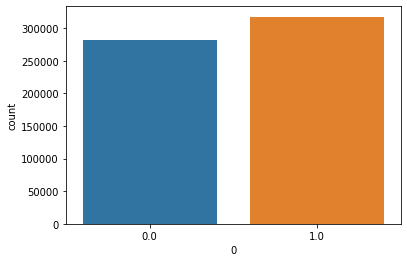

In [7]:
sns.countplot(x = 0, data=df)

In [8]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [186]:
EPOCHS = 50
BATCH_SIZE = 24
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 2
K=5
MAX_STEPS=10000
FLAG=True

In [11]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
#split training data into two subarrays based on class
X_train_class=[]
for i in range(NUM_CLASSES):
    X_train_class.append(np.ascontiguousarray(X_train[y_train == i]))
    
#Create Faiss index for each class
index(X_train_class[0],"IVF4096,PQ14","CLASS0")
index(X_train_class[1],"IVF4096,PQ14","CLASS1")


<class 'numpy.float32'>
traning
adding
ntotal after ivf:  203348
total train time:  17.482747793197632
saving at  CLASS0
total code time:  17.50075101852417
<class 'numpy.float32'>
traning
adding
ntotal after ivf:  228652
total train time:  17.84121298789978
saving at  CLASS1
total code time:  17.859216690063477


In [15]:
def get_class_distribution(obj):
    count_dict = {
        "class_0": 0,
        "class_1": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['class_0'] += 1
        elif i == 1: 
            count_dict['class_1'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

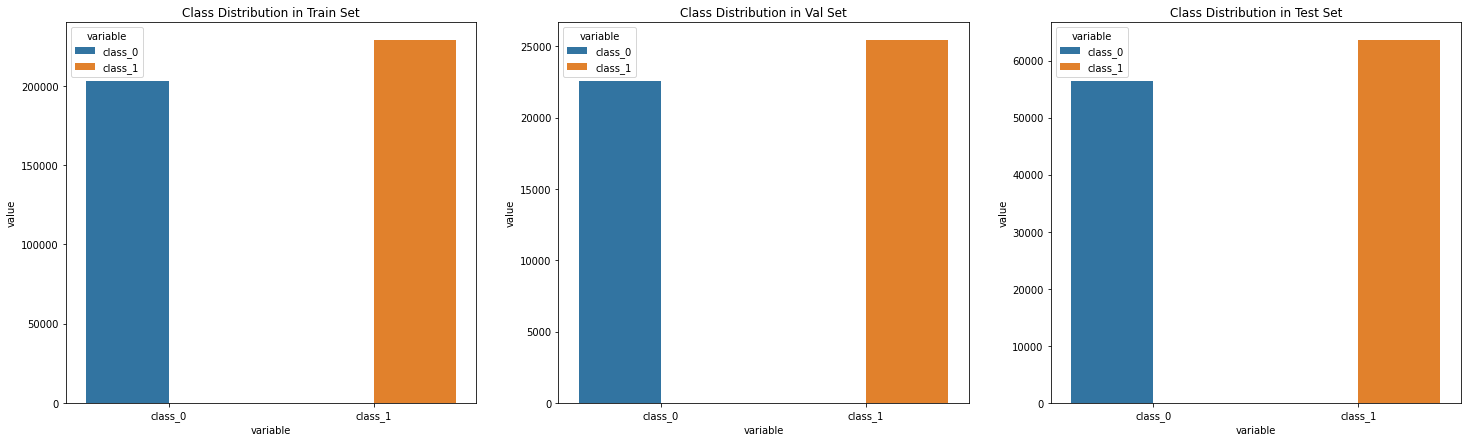

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [17]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [18]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [19]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([4.9177e-06, 4.3735e-06])


In [20]:
class_weights_all = class_weights[target_list]

In [21]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [22]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [23]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [136]:
import torch
from torch import autograd
from torch import nn


class CrossEntropyLoss(nn.Module):
    """
    This criterion (`CrossEntropyLoss`) combines `LogSoftMax` and `NLLLoss` in one single class.
    
    NOTE: Computes per-element losses for a mini-batch (instead of the average loss over the entire mini-batch).
    """
    log_softmax = nn.LogSoftmax()

    def __init__(self):
        super().__init__()
        
    def forward(self, x, target):
        log_softmax =  x - x.exp().sum(-1).log().unsqueeze(-1)
        loss = -log_softmax[range(target.shape[0]), target]

        return loss.mean(), loss.argsort()

In [137]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=28, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [26]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [197]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [144]:
def faissQuery(X_train_class, Queries):
    tempbatch=set()
    for i in range(NUM_CLASSES):
        distance, bucket = query(X_train_class[i].shape[1],X_train_class[i].shape[0],len(Queries[i]),False,np.array(Queries[i]),np.array(Queries[i]),f'CLASS{i}',100)
        for j in range(len(bucket)):
            for k in range(len(bucket[j])):
                #print("Class: ", i)
                #print("Query: ", Queries[i][j])
                #print("Neighbor: ", X_train_class[i][int(bucket[j][k])])
                tempbatch.add((int(bucket[j][k]),i))
    return tempbatch

In [173]:
#Should shuffle after creation?
def createBatch(tempbatch, LSHBatching=True):
    if LSHBatching:
        tempbatch=list(tempbatch)
        LSHbatch=random.choices(tempbatch, k=int(BATCH_SIZE/2))
        batchX = [X_train_class[x[1]][x[0]] for x in LSHbatch]
        batchY = [x[1] for x in LSHbatch]
        randomBatch0 = random.choices(X_train_class[0], k=int(BATCH_SIZE/4))
        randomBatch1 = random.choices(X_train_class[1], k=int(BATCH_SIZE/4))
        batchX = np.concatenate((batchX, randomBatch0, randomBatch1))
        batchY= np.concatenate((batchY, [0]*int(BATCH_SIZE/4), [1]*int(BATCH_SIZE/4)))
    else:
        randomBatch0 = random.choices(X_train_class[0], k=int(BATCH_SIZE/2))
        randomBatch1 = random.choices(X_train_class[1], k=int(BATCH_SIZE/2))
        batchX = np.concatenate((randomBatch0, randomBatch1))
        batchY= np.concatenate(([0]*int(BATCH_SIZE/2), [1]*int(BATCH_SIZE/2)))
    
    batchX, batchY = shuffle(batchX, batchY)
    
    return np.array(batchX), np.array(batchY).astype(np.int64)

In [194]:
X_train_LSH=X_train[0:BATCH_SIZE,:]
y_train_LSH=y_train[0:BATCH_SIZE].astype(np.int64)


In [195]:
LSHBatching=True

In [ ]:
print("Begin training.")
oldBatch = set()
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    step=0
    while(step<MAX_STEPS):
        X_train_batch= torch.from_numpy(X_train_LSH).to(device)
        y_train_batch=torch.from_numpy(y_train_LSH).to(device)

        ##why ? 
        optimizer.zero_grad()

        #timestampA = time.time()
        y_train_pred = model(X_train_batch.float())
        #print("Time for pred", time.time() - timestampA)

        #timestampB = time.time()
        train_loss, sorted_index = criterion(y_train_pred, y_train_batch)
        #print("Time for loss", time.time() - timestampB)

        if LSHBatching:
            #PROCEDURE FOR NEW BATCHES
            with torch.no_grad():
                #Find elements in batch that led to top K losses  
                X_train_batch_Topk = X_train_batch[sorted_index[-K:]]
                y_train_batch_Topk = y_train_batch[sorted_index[-K:]]

                #Query Faiss for nearest neighbors
                #timestampC = time.time()
                nextBatch = faissQuery(X_train_class,[X_train_batch_Topk[y_train_batch_Topk == 0], X_train_batch_Topk[y_train_batch_Topk == 1]])
                #print("Time for faiss query", time.time() - timestampC)

                #check for being stuck in cluster  
                #print("Similarity to old batch", len(nextBatch.intersection(oldBatch))/len(nextBatch.union(oldBatch)))
                oldBatch = nextBatch

                # Create new batch from neighbors and random sample
                #timestampD = time.time()
                X_train_LSH,y_train_LSH=createBatch(nextBatch)
                #print("Time for batch creation", time.time() - timestampD)

        else:
            with torch.no_grad():
                X_train_LSH,y_train_LSH=createBatch(nextBatch, LSHBatching)
        ##############################


        train_loss.backward()
        train_acc = multi_acc(y_train_pred, y_train_batch)

        optimizer.step()

        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        step+=1


    # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss, _ = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/MAX_STEPS)
    #len(train_loader)
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/MAX_STEPS)
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/MAX_STEPS:.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/MAX_STEPS:.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.57855 | Val Loss: 0.51969 | Train Acc: 69.142| Val Acc: 74.258
Epoch 002: | Train Loss: 0.57425 | Val Loss: 0.51699 | Train Acc: 69.556| Val Acc: 74.415
Epoch 003: | Train Loss: 0.57207 | Val Loss: 0.52022 | Train Acc: 69.624| Val Acc: 74.119
Epoch 004: | Train Loss: 0.56949 | Val Loss: 0.51758 | Train Acc: 69.934| Val Acc: 74.398
Epoch 005: | Train Loss: 0.56938 | Val Loss: 0.52038 | Train Acc: 69.865| Val Acc: 74.058
Epoch 006: | Train Loss: 0.57087 | Val Loss: 0.51645 | Train Acc: 69.728| Val Acc: 74.279
Epoch 007: | Train Loss: 0.56774 | Val Loss: 0.51563 | Train Acc: 70.041| Val Acc: 74.404
Epoch 008: | Train Loss: 0.56788 | Val Loss: 0.51518 | Train Acc: 69.986| Val Acc: 74.383
Epoch 009: | Train Loss: 0.56669 | Val Loss: 0.51685 | Train Acc: 70.165| Val Acc: 74.354
Epoch 010: | Train Loss: 0.56614 | Val Loss: 0.51496 | Train Acc: 70.164| Val Acc: 74.410
Epoch 011: | Train Loss: 0.56694 | Val Loss: 0.52080 | Train Acc: 70.182| Val Acc: 74.525
Epoch 012:

In [142]:

# print("Begin training.")
# for e in tqdm(range(1, EPOCHS+1)):

#   # TRAINING
#   train_epoch_loss = 0
#   train_epoch_acc = 0
#   model.train()
#   for X_train_batch, y_train_batch in train_loader:
#       X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
#       optimizer.zero_grad()
#       y_train_pred = model(X_train_batch)

#       train_loss, _ = criterion(y_train_pred, y_train_batch)
#       train_acc = multi_acc(y_train_pred, y_train_batch)


#       train_loss.backward()
#       optimizer.step()

#       train_epoch_loss += train_loss.item()
#       train_epoch_acc += train_acc.item()


#   # VALIDATION    
#   with torch.no_grad():

#       val_epoch_loss = 0
#       val_epoch_acc = 0

#       model.eval()
#       for X_val_batch, y_val_batch in val_loader:
#           X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

#           y_val_pred = model(X_val_batch)

#           val_loss, _ = criterion(y_val_pred, y_val_batch)
#           val_acc = multi_acc(y_val_pred, y_val_batch)

#           val_epoch_loss += val_loss.item()
#           val_epoch_acc += val_acc.item()
#   loss_stats['train'].append(train_epoch_loss/len(train_loader))
#   loss_stats['val'].append(val_epoch_loss/len(val_loader))
#   accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
#   accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


#   print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.63575 | Val Loss: 0.59693 | Train Acc: 63.536| Val Acc: 68.610
Epoch 002: | Train Loss: 0.60872 | Val Loss: 0.58203 | Train Acc: 66.880| Val Acc: 68.425
Epoch 003: | Train Loss: 0.59936 | Val Loss: 0.56765 | Train Acc: 67.800| Val Acc: 70.790
Epoch 004: | Train Loss: 0.59552 | Val Loss: 0.56389 | Train Acc: 68.088| Val Acc: 71.117
Epoch 005: | Train Loss: 0.59005 | Val Loss: 0.55879 | Train Acc: 68.568| Val Acc: 71.583
Epoch 006: | Train Loss: 0.58775 | Val Loss: 0.55882 | Train Acc: 68.727| Val Acc: 71.398
Epoch 007: | Train Loss: 0.58387 | Val Loss: 0.55276 | Train Acc: 69.095| Val Acc: 72.021
Epoch 008: | Train Loss: 0.58221 | Val Loss: 0.54949 | Train Acc: 69.205| Val Acc: 72.106
Epoch 009: | Train Loss: 0.58035 | Val Loss: 0.54973 | Train Acc: 69.409| Val Acc: 72.121
Epoch 010: | Train Loss: 0.57941 | Val Loss: 0.55026 | Train Acc: 69.481| Val Acc: 71.967


In [152]:
%pdb off

Automatic pdb calling has been turned OFF


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

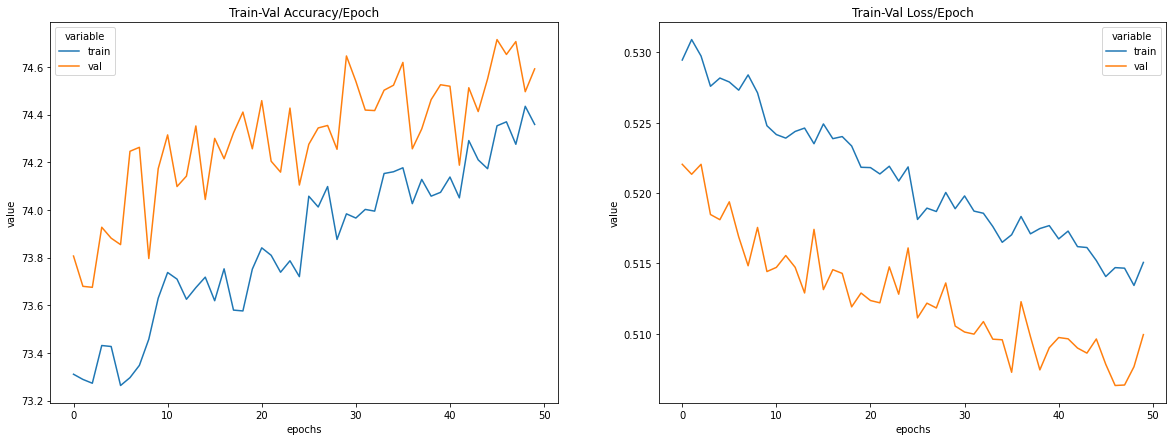

In [191]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [184]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [185]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

NameError: name 'idx2class' is not defined

In [ ]:
print(classification_report(y_test, y_pred_list))